**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
warnings.filterwarnings('ignore')

ds = LocalDataService()

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',#ETHUSDT:binance,EOSUSDT:binance
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax.grid(True)
    ax1.plot(alpha.iloc[-250:])
    alldays = mdates.DayLocator()                #副刻度为每天
    ax1.xaxis.set_minor_locator(alldays)          #设置副刻度
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%Y%m%d'))
    hoursLoc = mpl.dates.HourLocator(interval=2) #为6小时为1主刻度
    ax1.xaxis.set_major_locator(hoursLoc)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    for label in ax1.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
    ax1.tick_params(pad=10)
    ax1.grid(True)
    plt.show()

In [4]:
def RankPct(df):
    return df.rank(axis=1, pct=True)
alpha8_change = dv1H.add_formula('alpha8_C','-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))',add_data=True, register_funcs={'RankPct':RankPct})

In [5]:
alpha8_plot = dv1H.get_ts('alpha8_C', date_type='datetime')

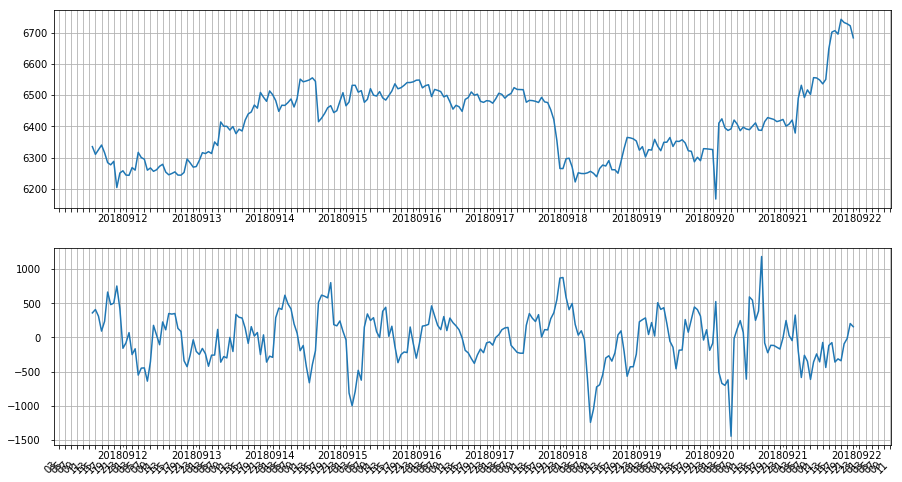

In [6]:
close = dv1H.get_ts('close', date_type='datetime')
plot_chart(close, alpha8_plot)

上图绘制了Alpha101因子中alpha8因子  
首先考察alpha8的定义：  
`alpha8_change = dv1H.add_formula('alpha8_C','-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))',add_data=True,register_funcs={'RankPct':RankPct})`  
  
经查阅add_formula支持的内置公式可知其中：  
`Ts_Sum(x,n)`表示指标在过去n天的和  
`Return(x,n,log)`表示计算指标相比n天前的变化率，默认计算百分比变化率；当log为1时，计算对数变化率;为0时计算普通变化率'  
`Delay(x,n)`表示指标n个周期前的值  
  
公式中：  
`Ts_Sum(open,5)`为即5个周期开盘价的和；  
`Ts_Sum(Return(close,1),5)`为5个周期回报率的和；  
`Ts_Sum(open, 5)*Ts_Sum(Return(close,1),5)`表示5个周期开盘价的和乘以5个周期回报率的和得到的一个指标，反映现势头的大小；  
`delay((Ts_Sum(open, 5)*Ts_Sum(Return(close,1), 5)), 10)`得到了10个周期前5个周期开盘价的和乘以5个周期回报率得到的一个指标，反映10个周期前该势头的大小；  
`Ts_Sum(open, 5)*Ts_Sum(Return(close,1),5)-delay((Ts_Sum(open, 5)*Ts_Sum(Return(close,1), 5)), 10)`表示了当前周期与10个周期前的这个反映了势头的指标差值；
`-1*rank（…）`用作排序，以当前势头减去10个周期前的势头得到对应结果,对所有股票进行排序后的排名乘以-1使得大小越大的即为排名越前的  

该指标表征了股票势头的相对强弱  

从上面收盘价与alpha8因子的图像的关系来看，比特币价格在不停波动，alpha8因子放大了价格的波动，但是该因子的“放大系数”并非是不变的，它对于close价格中微小的起伏的“放大系数”较大，而价格发生较大抖动时alpha8的放大效果没有那么明显。此外，alpha8因子相对于close的走势是有一定滞后的，滞后的程度是公式中Delay()的参数决定的，上图中使用的参数是10个周期，本例中就是10个小时，如果想减小这种滞后可以将此参数调整得小一些。

In [7]:
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance', 
         'freq': '1H', 'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

In [8]:
from matplotlib.pylab import date2num
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date()
    ax1.plot(data1H.index, data1H.volume)
    alldays = mdates.DayLocator()                #主刻度为每天
    ax1.xaxis.set_major_locator(alldays)          #设置主刻度
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
    for label in ax1.get_xticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('right')
    ax1.tick_params(pad=10)
    ax1.grid(True)
    plt.show()

data1H = Time_dict.set_index('datetime')
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [9]:
morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


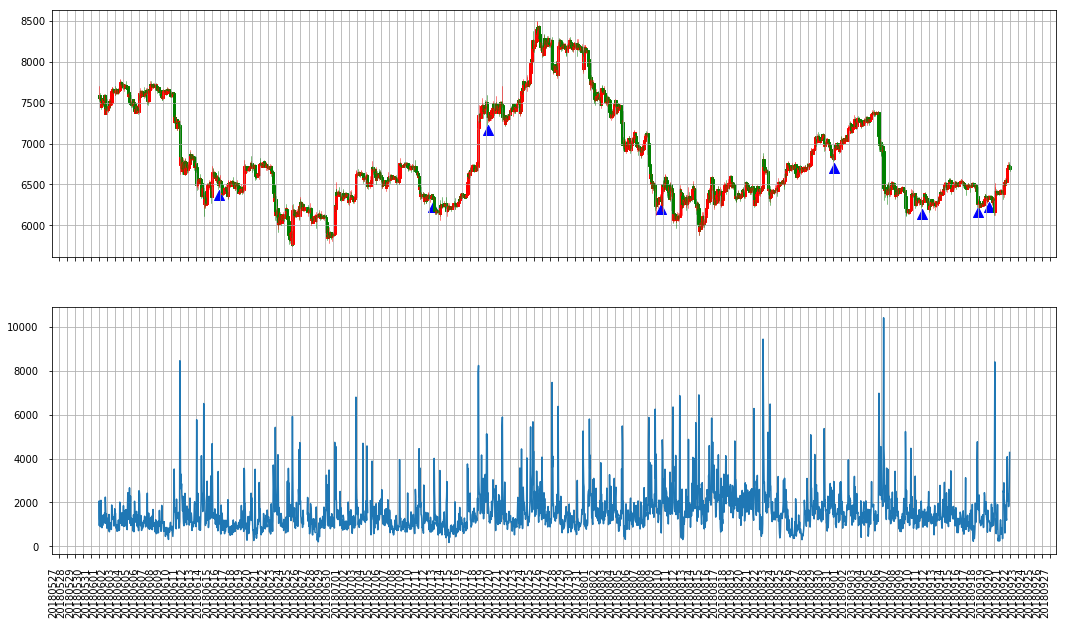

In [10]:
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index
morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

上图调用了candleresearch中的morningstar因子，绘制了蜡烛图用来寻找反转信号。晨星图是三日K线模式，下跌趋势，第一日阴线，第二日价格振幅较小，第三天阳线，预示底部反转。图中的蓝色三角号表征了反转节点。

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

**1.alpha 101 #008因子与价格的联系**  
如前文所述，alpha8因子表征了股票势头的相对强弱，当势头强到一定程度时会变弱，过弱时同理。  
从close图与008因子的图中可以看出，alpha8的尖峰（局部最大值）往往对应着close图中一个较低的价格，即释放了买入信号，而alpha8的局部最小值往往对应着close图中的一个较高的价格，释放了卖出信号。  
通过更细致的观察发现，这种相关关系在500到-500的区间内并不显著，在大于500以及小于-500时信号更加清晰。  
进场假设：alpha8出现小于-500的局部最小值  
出场假设：alpha8出现大于500的局部最大值  
**2.蜡烛图与成交量的联系**  
在对照蜡烛图中morningstar和成交量时未发现很显著的相关关系，但是成交量在接近2000的时候出现morningstar的可能性高于其他成交量下的情况。  
进场信号：成交量不超过2000上下浮动5%。

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
